In [1]:
import tensorflow as tf

from tensorflow.keras import Model, models, layers, losses 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.backend import batch_normalization 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/CS231N')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def vgg16():
    model = Sequential()
    model.add(MaxPooling2D((3,3), strides=(3,3), padding='valid', input_shape=(1394, 1162, 4)))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dense(units=2, activation="softmax"))
    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2 = 0.999)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy', 'Precision'])
    
    return model

In [3]:
model = vgg16()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2D  (None, 464, 387, 4)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 232, 193, 4)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 232, 193, 64)      2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 232, 193, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 116, 96, 64)      0         
 2D)                                                             
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
files = os.listdir('/content/drive/My Drive/CS231N/Matrices2')

train_files = files[:396]
test_files = files[396:]

def make_inputs(inputs):
    train_x = []
    train_y = []
    
    date_list = ['2022-March','2021-May','2021-March','2020-December', '12:17:20', '2:17:20', '3:8:22', 
                 '5:22:21', '7:9:20']
    for file in inputs:
        #Got error when labels went from 1-4 instead of 0-3
        if file[3:-4] == '2022-March' or file[2:-4] == '2022-March' or file[4:-4] == '2022-March':
            train_y.append(0)
        if file[3:-4] == '2021-May' or file[2:-4] == '2021-May' or file[4:-4] == '2021-May':
            train_y.append(0)
        if file[3:-4] == '2021-March' or file[2:-4] == '2021-March' or file[4:-4] == '2021-March':
            train_y.append(1)
        if file[3:-4] == '2020-December' or file[2:-4] == '2020-December' or file[4:-4] == '2020-December':
            train_y.append(1)
        if file[3:-4] == '12:17:20' or file[2:-4] == '12:17:20' or file[4:-4] == '12:17:20':
            train_y.append(1)
        if file[3:-4] == '3:8:22' or file[2:-4] == '3:8:22' or file[4:-4] == '3:8:22':
            train_y.append(0)
        if file[3:-4] == '5:22:21' or file[2:-4] == '5:22:21' or file[4:-4] == '5:22:21':
            train_y.append(0)
        if file[3:-4] == '7:9:20' or file[2:-4] == '7:9:20' or file[4:-4] == '7:9:20':
            train_y.append(1)
        
        if file[3:-4] in date_list or file[2:-4] in date_list or file[4:-4] in date_list:
            #print(file)
            train_x.append(cv2.resize(np.load(f'/content/drive/My Drive/CS231N/Matrices2/{file}'), (1162, 1394)))

    train_x = np.asarray(train_x)
    train_y = np.asarray(train_y).reshape(len(train_y),1)
    train_y = to_categorical(train_y)
    
    return train_x, train_y

In [6]:
train_x, train_y = make_inputs(train_files)
test_x, test_y = make_inputs(test_files)

In [7]:
print(train_x.shape)
print(train_y.shape)
print('----')
print(test_x.shape)
print(test_y.shape)

(396, 1394, 1162, 4)
(396, 2)
----
(20, 1394, 1162, 4)
(20, 2)


In [8]:
tf.config.run_functions_eagerly(True)

In [9]:
result1 = model.fit(train_x, train_y, epochs=50, batch_size=10,validation_data=(test_x, test_y))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
40/40 [==============================] - 27s 315ms/step - loss: 538.2858 - accuracy: 0.5177 - precision: 0.5177 - val_loss: 0.6949 - val_accuracy: 0.4500 - val_precision: 0.4500
Epoch 2/50
40/40 [==============================] - 10s 250ms/step - loss: 0.7072 - accuracy: 0.5025 - precision: 0.5025 - val_loss: 0.6959 - val_accuracy: 0.4500 - val_precision: 0.4500
Epoch 3/50
40/40 [==============================] - 10s 249ms/step - loss: 0.6936 - accuracy: 0.5025 - precision: 0.5025 - val_loss: 0.6939 - val_accuracy: 0.4500 - val_precision: 0.4500
Epoch 4/50
40/40 [==============================] - 10s 257ms/step - loss: 0.6934 - accuracy: 0.4773 - precision: 0.4773 - val_loss: 0.6934 - val_accuracy: 0.4500 - val_precision: 0.4500
Epoch 5/50
40/40 [==============================] - 10s 253ms/step - loss: 0.6938 - accuracy: 0.5025 - precision: 0.5025 - val_loss: 0.6939 - val_accuracy: 0.4500 - val_precision: 0.4500
Epoch 6/50
40/40 [==============================] - 10s 252ms/s

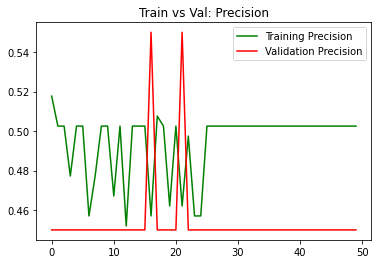

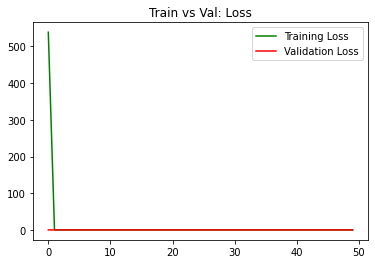

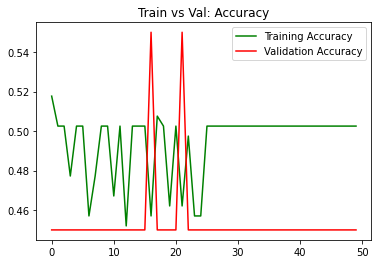

<Figure size 432x288 with 0 Axes>

In [10]:
precision = result1.history['precision']
loss = result1.history['loss']
accuracy = result1.history['accuracy']
val_precision = result1.history['val_precision']
val_loss = result1.history['val_loss']
val_accuracy = result1.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs, precision, 'g', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Train vs Val: Precision')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train vs Val: Loss')
plt.legend()
plt.figure()
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train vs Val: Accuracy')
plt.legend()
plt.figure()
plt.show()

In [5]:
print(len(files))
#print(len(train_x))
#print(len(test_x))
processed_files = {}
for file_name in files:
  file = file_name[2:-4]

  if file[0] == '-':
    file = file[1:]
  if file[0] == ' ':
    file = file[1:]
  if file[1] == '-':
    file = file[2:]
  processed_files[file_name] = file
print(len(processed_files.values()))

416
416


In [6]:
count_dict = {}
for file in files:
  count_dict[re.split(' |\-', file)[0]] = []

for file in files:
  key = re.split(' |\-', file)[0]
  count_dict[key].append(file)



In [7]:
train_dict = {}
test_dict = {}
for key in count_dict.keys():
  if len(count_dict[key]) == 4:
    val = count_dict[key]
    train_dict[key] = val
  if len(count_dict[key]) == 2:
    val = count_dict[key]
    test_dict[key] = val
print(len(count_dict.keys()))
print(len(train_dict.keys()))
print(len(test_dict.keys()))

110
98
12


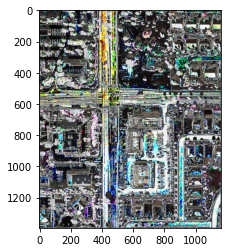

(1394, 1162, 4)


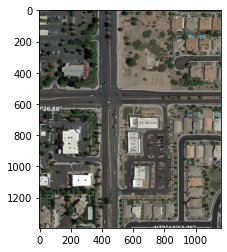

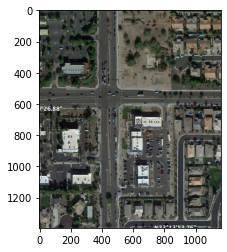

In [9]:
counter = 0
output_array = []
for key in train_dict.keys():
  val = list(train_dict[key])
  img1 = cv2.resize(np.load(f'/content/drive/My Drive/CS231N/Matrices2/{val[0]}'), (1162, 1394))
  img2 = cv2.resize(np.load(f'/content/drive/My Drive/CS231N/Matrices2/{val[1]}'), (1162, 1394))
  diff = img1 - img2
  diff = diff + np.array([0,0,0,255])
  plt.imshow(diff)
  plt.show()
  print(diff.shape)
  plt.imshow(img1)
  plt.show()
  plt.imshow(img2)
  plt.show()
  break

In [10]:
diff.shape

(1394, 1162, 4)

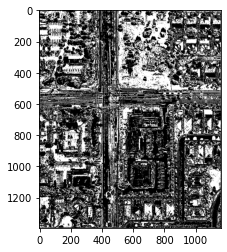

In [11]:
hsv_color1 = np.asarray([0,0,0,255])   # white!
hsv_color2 = np.asarray([138,43,226,255])   # yellow! note the order

output = cv2.inRange(diff, hsv_color1, hsv_color2)
plt.imshow(output, cmap='gray')   # this colormap will display in black / white
plt.show()

(1394, 1162)


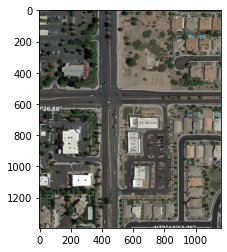

In [12]:
print(output.shape)
#plt.imshow(np.multiply(output, img1))
plt.imshow(img1[:,:,:])
plt.show()


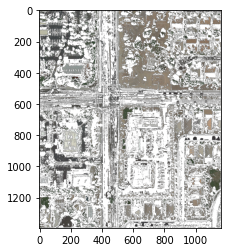

In [13]:
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        if output[i][j] == 0:
            img1[i][j] = [0,0,0,0]
plt.imshow(img1)
plt.show()

In [16]:
def make_inputs_mask(input_dict):
  output_array = []
  output_labels = []
  for key in tqdm(input_dict.keys()):
    value = list(input_dict[key])
    img1 = cv2.resize(np.load(f'/content/drive/My Drive/CS231N/Matrices2/{value[0]}'), (1162, 1394))
    img2 = cv2.resize(np.load(f'/content/drive/My Drive/CS231N/Matrices2/{value[1]}'), (1162, 1394))
    diff = img1 - img2
    diff = diff + np.array([0,0,0,255])

    hsv_color1 = np.asarray([0,0,0,255])   # white!
    hsv_color2 = np.asarray([138,43,226,255])   # yellow! note the order

    output = cv2.inRange(diff, hsv_color1, hsv_color2)

    for val in value:
      img = cv2.resize(np.load(f'/content/drive/My Drive/CS231N/Matrices2/{val}'), (1162, 1394))
      foo = output/255
      test = np.repeat(foo[:,:,np.newaxis], 4,axis=2)
      img = np.multiply(test, img)
      output_array.append(img)
      if '2020' in val:
        output_labels.append(1)
      elif ':20' in val:
        output_labels.append(1)
      else:
        output_labels.append(0)

  output_array = np.asarray(output_array)
  output_labels = np.asarray(output_labels).reshape(len(output_labels),1)
  output_labels = to_categorical(output_labels)
    
  return output_array, output_labels    
   

In [ ]:
mask_train_x, mask_train_y = make_inputs_mask(train_dict)
mask_test_x, mask_test_y = make_inputs_mask(test_dict)

 46%|████▌     | 45/98 [00:29<00:43,  1.21it/s]

In [ ]:
result = model.fit(mask_train_x, mask_train_y, epochs=50, batch_size=10,validation_data=(mask_test_x, mask_test_y))

In [ ]:
precision = result.history['precision']
loss = result.history['loss']
accuracy = result.history['accuracy']
val_precision = result.history['val_precision']
val_loss = result.history['val_loss']
val_accuracy = result.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs, precision, 'g', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Train vs Val: Precision')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train vs Val: Loss')
plt.legend()
plt.figure()
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train vs Val: Accuracy')
plt.legend()
plt.figure()
plt.show()